## Clustering of Mall Customers using Kmeans++ Algorithm
### Data Analytics with PySpark
- Paolo G. Hilado

#### <font color='steelblue'>SITUATIONER:</font> The administration is looking to cluster their customers in terms of features such as sex, age, annual income (in thousand), and spending score. This is to be used in making decisions for marketing and promotions purposes.

In [1]:
# Import the necessary packages
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext(master = 'local[6]')
import pandas as pd
import numpy as np
from pyspark.mllib.clustering import KMeans, KMeansModel
import matplotlib.pyplot as plt
import researchpy as rp

In [141]:
# Loading and Describing the Data
dfa = pd.read_csv('Mall_Customer_Profile.csv')

In [142]:
# Work on necessary features
dfa = dfa.iloc[:, 3:]
dfa.head(2), dfa.info() # Data has 1000 entries with 5 features; 1st feature is unnecessary,
# 'Sex' is binary while 'Age', 'AnnInc' and 'Spend' seems to have been Standardized.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5712 entries, 0 to 5711
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sex       5712 non-null   object
 1   Age       5712 non-null   int64 
 2   AnnInc    5712 non-null   int64 
 3   SpendScr  5712 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 178.6+ KB


(      Sex  Age  AnnInc  SpendScr
 0  Female   38     113        91
 1    Male   35      93        90,
 None)

In [139]:
dfa.isnull().sum() #All necessary data cleaning have been made and we are ready for clustering

Sex         0
Age         0
AnnInc      0
SpendScr    0
dtype: int64

In [143]:
# Standardize all continuous variables
from sklearn.preprocessing import StandardScaler
ndf = pd.DataFrame(StandardScaler().fit_transform(dfa.iloc[:, 1:]))
ndf.rename(columns = {0:"Age", 1:"AnnInc", 2:"Spend"}, inplace = True)
ndf.head()

,Age,AnnInc,Spend
0,-0.037980,2.038968,1.573652
1,-0.255213,1.268319,1.534643
2,-1.196554,-1.544549,1.105545
3,-1.268965,-1.159225,0.871492
4,1.265416,0.728865,-0.610846


In [144]:
# Set up categorical variables for Sex
dfa = pd.get_dummies(dfa, columns=['Sex'])
dfa = dfa[["Sex_Male", "Sex_Female", "Age", "AnnInc", "SpendScr"]]

In [69]:
# Organize the data set for modelling
df = pd.concat([dfa.iloc[:, 0], ndf], axis = 1)
df.head(5)

,Sex_Male,Age,AnnInc,Spend
0,0,-0.037980,2.038968,1.573652
1,1,-0.255213,1.268319,1.534643
2,1,-1.196554,-1.544549,1.105545
3,0,-1.268965,-1.159225,0.871492
4,0,1.265416,0.728865,-0.610846


In [8]:
# Partitioning the data set with 80-20 train_test_split
from sklearn.model_selection import train_test_split

In [70]:
features = df.drop('Spend', axis = 1)
label = df['Spend']
xtrain, xtest, ytrain, ytest = train_test_split(features, label, test_size = 0.2, random_state=100) 
train = pd.concat([xtrain, ytrain], axis = 1)
test = pd.concat([xtest, ytest], axis = 1)
train.shape, test.shape

((4569, 4), (1143, 4))

In [71]:
# Enable parallel processing with PySpark
rddtrain = sc.parallelize(train.values)
rddtest = sc.parallelize(test.values)

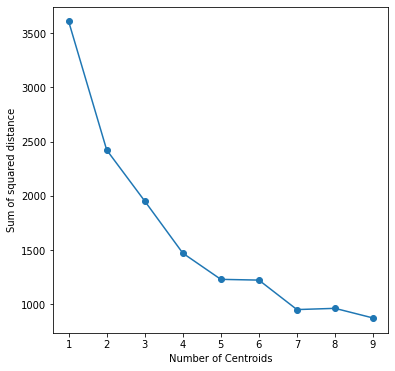

In [72]:
import matplotlib.pyplot as plt
# Determine the right number of centroids using the 'elbow' method
# As shown by the visualization below, it looks like 4 centroids would be appropriate.
sse = []
list_k = list(range(1,10))

for i in list_k:
    mdl = KMeans.train(rddtrain, k= i, initializationMode = 'k-means||', maxIterations = 100)
    err = mdl.computeCost(rddtest)
    sse.append(err)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of Centroids')
plt.ylabel('Sum of squared distance');

In [73]:
# Now let us create the model with 5 centroids which we will use for clustering
model = KMeans.train(rddtrain, k = 4, maxIterations=100, initializationMode = 'k-means||')
pred = model.predict(rddtest)
predict = pred.collect()
dfclust = pd.concat([test.reset_index(drop = True), pd.DataFrame(predict)], axis = 1)
dfclust = dfclust.rename(columns = {0: 'Cluster'})

In [75]:
# Showing the first ten rows now with cluster labels
dfclust.head(5)

,Sex_Male,Age,AnnInc,Spend,Cluster
0,0,0.541307,-0.234446,-0.259766,0
1,0,-1.124144,0.382073,-0.844899,2
2,0,-0.037980,0.150878,-0.337783,2
3,0,-1.124144,0.382073,-0.844899,2
4,0,-0.255213,2.308695,1.105545,1


In [131]:
# Generate a frequency distribution of the clusters in the data frame
rp.summary_cat(dfclust['Cluster'])

,Variable,Outcome,Count,Percent
0,Cluster,0,367,32.11
1,,3,342,29.92
2,,1,223,19.51
3,,2,211,18.46


In [145]:
# Check out the profile of customers per cluster
dfa = pd.concat([dfa, dfclust.iloc[:, 4]], axis = 1)
x = np.round(dfa.iloc[:,2:].groupby("Cluster").mean(),0)
y = dfa.groupby("Cluster").sum()
res = pd.concat([y.iloc[:,:2], x], axis=1)
res

,Sex_Male,Sex_Female,Age,AnnInc,SpendScr
Cluster,,,,,
0.0,167,200,39.0,62.0,48.0
1.0,95,128,39.0,60.0,52.0
2.0,79,132,39.0,61.0,49.0
3.0,137,205,40.0,59.0,47.0


#### <font color='steelblue'>Insights from the Clustering Model:</font>
- Cluster 1 tend to have highest mean spending score (52) among all other clusters, having an estimated mean annual income of 60k dollars; advertisements on premium products would well be targeted to customers within this cluster. On the other hand, Cluster 3 presents the customers with the lowest mean spending score (47). Promotions and adverstisements on cost-effective products would well be targeted to this cluster of customers.  